## Implementação de um Classificador Perceptron

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

%matplotlib inline

In [275]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y, verbose=False):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in (tqdm(range(self.n_iter)) if verbose else range(self.n_iter)):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Testando o classificador Perceptron

In [276]:
"""Dados de Treinamento """
X = np.array([[1, 1], 
              [2, 2],
              [3, 3]])
y = np.array([1, 1, -1])
X, y

(array([[1, 1],
        [2, 2],
        [3, 3]]),
 array([ 1,  1, -1]))

In [277]:
"""Criando objeto Perceptron"""
ppn = Perceptron(eta=0.1, n_iter=100)

"""Treinando o modelo"""
ppn.fit(X, y)

"""Testando modelo treinado """
X_newdata = np.array([[4, 4],
                      [2, 2],
                      [3, 3]])

print("Resultado da Predição", ppn.predict(X_newdata))

Resultado da Predição [-1  1 -1]


## Questão 1 - Implemente uma função para calcular a acurácia do modelo

In [278]:
def compute_accuracy_score(y_true, y_pred, normalize=True):
    """Accuracy classification score for that model.

    Parameters:
    -----------
    y_true: 1d array
        The ground-truth array.
    y_pred: 1d array
        Predicted values for that arrangement
    normalize: bool, optional (default=True)
        If True returns the fraction of correcly classified samples.
        Returns the number of classifications samples otherwise.
    """
    score = y_true == y_pred

    if normalize:
        return score.sum()/score.shape[0]
    return score.sum()

## Questão 2 - Implemente um método de validação cruzada para testar 

In [279]:
from numpy.random import shuffle
from sklearn.model_selection import train_test_split, cross_val_score

In [280]:
def compute_cross_val_score(X, y, estimator=None, cv=5):
    """Generate evaluation scores by using cross-validation

    Parameters
    ----------
    estimator
    X
    y
    cv

    Returns
    -------
    scores: array
        The scores for each run of cross-validation


    Algorithm Scratch
    -----------------
    Steps to perform the scores computation

    Concatenate X and y: new matrix 'data' will have length 'm'
    Shuffle 'data' randomly    
    Split 'data' into 'k' sets (k = cv) in order to perform cross validation.
    Each set should have length m/k.

    For each unique group:
        1) Take the group as a hold out or test dataset
        2) Take the remaining groups as a training set
        3) Fit a model on the training set and evaluate it on the test set.
        4) Retain the evaluation score and discard the model

    Summarize the skill of the model using the sample of model evaluation scores
    """
    y = y.reshape((y.shape[0], 1))
    data = np.concatenate((X, y), axis=1)
    
    shuffle(data)

    m = data.shape[0]
    k, r = np.divmod(m, cv)
    k, r = int(k), int(r)

    folds = []

    for i in range(cv):
        if (i+1)*k < (m-r):
            folds.append(data[(i*k):(i+1)*k])
        else:
            folds.append(data[(i*k):((i+1)*k)+r])
    
    scores = []

    for i, fold in enumerate(folds):
        training_set = [fold for j, fold in enumerate(folds) if i!=j]
        training_set = [item for sublist in training_set for item in sublist]
        training_set = np.matrix(training_set)
        training_set = np.squeeze(np.asarray(training_set))
        
        X_train, y_train = training_set[:, :-1], training_set[:, -1]
        X_val, y_val = fold[:, :-1], fold[:, -1]
                
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_val)
        score = float(compute_accuracy_score(y_val, y_pred, normalize=True))
        scores.append(score) # val is the current i - current validation set index
    
    return scores

## Teste o classificador usando um conjunto de dados linearmente separável e outro não linearmente separável
### Sugestão: crie datasets sintéticos com apenas dois atributos para você poder visualizar a separação das classes

In [281]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

#### Part I

##### 1) Creating a linearly separable dataset:

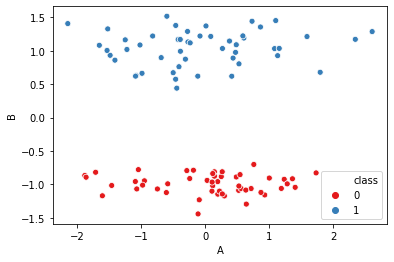

In [282]:
separable = False

while not separable:
    samples = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])


df1 = pd.DataFrame(columns=['A', 'B', 'class'])
df1['A'] = samples[0][:, 0]
df1['B'] = samples[0][:, 1]
df1['class'] = samples[1]

sns.scatterplot(x=df1['A'], y=df1['B'], hue=df1['class'], palette='Set1')

##### 2) Creating model

In [283]:
# Instantiate Perceptron object
ppn1 = Perceptron(eta=0.1, n_iter=100)

# Split data into training and test sets using Scikit-Learn module
X, y = df1[['A', 'B']], df1['class']
X, y = X.to_numpy(), y.to_numpy()

##### 3) Cross-validating the dataset

In [284]:
scores = compute_cross_val_score(X, y, ppn1, cv=4)
print(f"Cross-validation scores: {scores}") 
print(f"Average: {np.average(scores)}")

Cross-validation scores: [0.52, 0.36, 0.6, 0.52]
Average: 0.5


#### Part II

##### 1) Creating a linearly non-separable dataset:

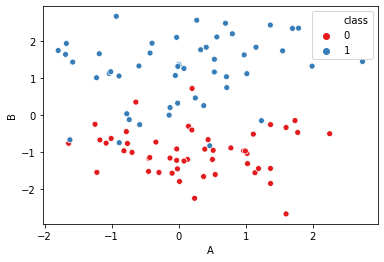

In [294]:
samples = make_classification(n_samples=100, n_features=2, n_redundant=0,
                              n_informative=1, n_clusters_per_class=1, flip_y=-1)

df2 = pd.DataFrame(columns=['A', 'B', 'class'])
df2['A'] = samples[0][:, 0]
df2['B'] = samples[0][:, 1]
df2['class'] = samples[1]

sns.scatterplot(x=df2['A'], y=df2['B'], hue=df2['class'], palette='Set1')

##### 2) Creating model

In [295]:
# Instantiate Perceptron object
ppn2 = Perceptron(eta=0.1, n_iter=100)

# Split data into training and test sets using Scikit-Learn module
X, y = df2[['A', 'B']], df2['class']
X, y = X.to_numpy(), y.to_numpy()

##### 3) Cross-validating the dataset

In [296]:
scores = compute_cross_val_score(X, y, ppn2, cv=4)
print(f"Cross-validation scores: {scores}") 
print(f"Average: {np.average(scores)}")

Cross-validation scores: [0.68, 0.4, 0.24, 0.56]
Average: 0.47000000000000003


## Questão 3 - Treine um classificador perceptron para os dados de seu estudo de caso

For simplicity matters let's use the [**Iris Plants dataset**](https://archive.ics.uci.edu/ml/datasets/iris):

##### 1) Getting data ready

In [288]:
from sklearn.datasets import load_iris, load_breast_cancer

iris = load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])

# Working with two classes only: ditch virginica class
df = df[df['target'] != 2.0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  100 non-null    float64
 1   sepal width (cm)   100 non-null    float64
 2   petal length (cm)  100 non-null    float64
 3   petal width (cm)   100 non-null    float64
 4   target             100 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB


##### 2) Creating model

In [289]:
# Instantiate Perceptron object
ppn = Perceptron(eta=0.1, n_iter=100)

columns_list = list(df.columns)[:4]

# Split data into training and test sets using Scikit-Learn module
X, y = df[columns_list], df['target']
X, y = X.to_numpy(), y.to_numpy()

##### 3) Cross-validating the dataset

In [290]:
scores = compute_cross_val_score(X, y, ppn, cv=3)
print(f"Cross-validation scores: {scores}") 
print(f"Average: {np.average(scores)}")

Cross-validation scores: [0.6060606060606061, 0.36363636363636365, 0.5294117647058824]
Average: 0.4997029114676173


## EXTRA: Performing a simple test using MultiLayer Perceptron

In [291]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

scores = compute_cross_val_score(X, y, mlp, cv=3)
print("Using functions implemented before: ")
print(f"Cross-validation scores: {scores}") 
print(f"Average: {np.average(scores)}")

scores = cross_val_score(mlp, X, y, cv=3)
print("\nUsing built-in scikit-learn Python modules: ")
print(f"Cross-validation scores: {scores}") 
print(f"Average: {np.average(scores)}")

Using functions implemented before: 
Cross-validation scores: [0.36363636363636365, 0.42424242424242425, 0.29411764705882354]
Average: 0.36066547831253715

Using built-in scikit-learn Python modules: 
Cross-validation scores: [0.5        0.48484848 0.48484848]
Average: 0.4898989898989899
